In [1]:
import os
from keras import Sequential,Model
from keras.layers import Dense,Flatten,MaxPooling2D,Convolution2D,Activation,BatchNormalization,Softmax,Dropout,GlobalMaxPool2D,GlobalAveragePooling2D
from keras import optimizers
import numpy as np
import sklearn
import random
from pathlib import Path

from keras import callbacks
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16



Using TensorFlow backend.


In [2]:
p = Path("./cell_images/")
dirs=p.glob('*')
label_dict={'Uninfected':0,'Parasitized':1}
label2class={0:'Uninfected',1:'Parasitized'}
image_data=[]
labels=[]
image_paths=[]
image_data = []
labels = []

#Optional
image_paths = []

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    cnt = 0
    #Iterate over folder_dir
    for img_path in folder_dir.glob("*.png"):
        
        img = image.load_img(img_path,target_size=(100,100))
        img_array= image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])
        cnt += 1
        
    print(cnt)

13779
13779


In [3]:
print(labels[:10])
combined = list(zip(image_data,labels))
random.seed(4)
random.shuffle(combined)
image_data[:],labels[:] = zip(*combined)
x=np.array(image_data)
y=np.array(labels)
x=x/255.0
print(y[:10])


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 1 0 0 0 1 0 1]


In [4]:
from keras.utils import np_utils
x_train=x[:int(x.shape[0]*0.8),:]
y_train=y[:int(y.shape[0]*0.8)]
x_test=x[x_train.shape[0]:x.shape[0],:]
y_test=y[y_train.shape[0]:y.shape[0]]
y_test=np_utils.to_categorical(y_test)
y_train=np_utils.to_categorical(y_train)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(22046, 100, 100, 3) (22046, 2) (5512, 100, 100, 3) (5512, 2)


In [5]:
res_model = VGG16(include_top=False,weights='imagenet', input_shape=(100,100,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [14]:

av1 = GlobalAveragePooling2D()(res_model.output)
fc1 = Dense(512, activation='relu')(av1)
drp1=Dropout(0.25)(fc1)
fc2 = Dense(256, activation='relu')(drp1)
drp2=Dropout(0.25)(fc2)
bat_norm=BatchNormalization()(drp2)
fc3 = Dense(64, activation='relu')(bat_norm)
out = Dense(2, activation='softmax')(fc3)

tl_model = Model(inputs=res_model.input,outputs=out)
tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [0]:
ada = optimizers.adam(lr=1e-5, decay=5e-4)
tl_model.compile(loss='categorical_crossentropy', optimizer=ada, metrics=["mae",'accuracy'])

In [0]:
hist = tl_model.fit(x_train,y_train,epochs=20,shuffle=True,batch_size=64,validation_split=0.20)

In [9]:
tl_model.evaluate(x_test,y_test)
y_predicted=tl_model.predict(x_test)
y_predicted=np.argmax(y_predicted,axis=1)
print(y_predicted)

5512/5512 [==============================] - 17s 3ms/step


[0.1708138197294135, 0.03921722838873414, 0.9637155297532656]

In [10]:


y_test_score=y[y_train.shape[0]:y.shape[0]]

[1 1 0 ... 0 0 0]


In [11]:

from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']

print(classification_report(y_test_score, y_predicted, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.95      0.98      0.96      2718
     class 2       0.98      0.95      0.96      2794

   micro avg       0.96      0.96      0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [12]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test_score, y_predicted)
print(confusion)
TP = confusion[1, 1]

# True Negatives
TN = confusion[0, 0]

# False Positives
FP = confusion[0, 1]

# False Negatives
FN = confusion[1, 0]

###precision/sensitivity
print(TP/float(TP+FP))
###recall/specificity
print(TP/float(TP+FN))
      

[[2663   55]
 [ 145 2649]]
0.9796597633136095
0.9481030780243379


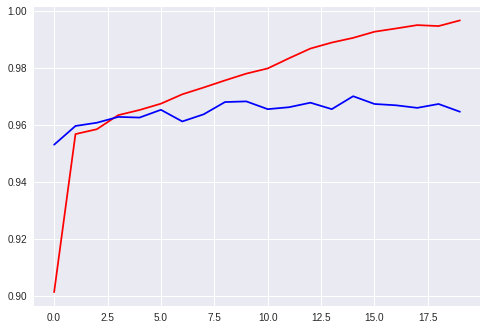

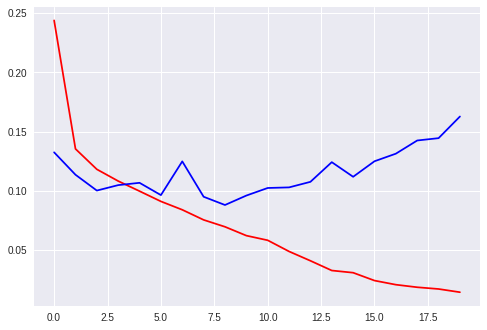

In [13]:
plt.figure(0)
plt.plot(hist.history['acc'],'r')
plt.plot(hist.history['val_acc'],'b')


plt.figure(1)
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')

plt.show()